# <center><b>Data for statup case project</b></center>

<center> <b>The movie recommandation system </b> </center>

## <b> Context

In a world where digital material is abundant and constantly evolving, it's increasingly challenging for users to find content that match their tastes and preferences. Facing this information overload, recommendation systems play a crucial role in personalizing the user experience by filtering and suggesting relevant content. 

With the rising popularity of streaming platforms and the diversification of cinematic tastes, there is a significant need for personalized and accurate movie recommendations. Users seek to discover films that not only match their current tastes but also enable them to explore new genres and filmmakers. The primary objective of this project is to develop a movie recommendation system that offers a personalized experience to each user. By analyzing user data and utilizing machine learning models, the system will provide movie suggestions that are not only popular but also aligned with the individual preferences of the user.

The project will use modern web scraping techniques to collect data from online sources such as IMDb and Rotten Tomatoes. This data will be stored and managed using Google BigQuery, allowing for efficient analysis and quick retrieval. For recommendations, various machine learning algorithms will be explored and tested. Data visualization will be done via Tableau or Python libraries, for in-depth analysis of trends and performance. Finally, a Flask API will be developed for interaction with the end users.

## <b> How to build a movie recommandation system

Recommender systems can be categorized into three primary types, each with its unique approach:

- Demographic Filtering: This method provides general recommendations to users based on the popularity and/or genre of movies. It assumes that users with similar demographic characteristics have the same cultural backgroud and will therefor enjoy similar movies. While this system favors movies that are widely popular and critically acclaimed, it may oversimplify user preferences, as it does not account for the individual differences among users.

- Content-Based Filtering: This approach recommends items by focusing on the properties of the items themselves. For movies, it utilizes metadata like genre, director, description, and actors to find and suggest similar movies. The underlying principle is that if a user likes a certain movie, they are likely to enjoy other movies with similar characteristics.

- Collaborative Filtering: This system identifies users with similar tastes and preferences to make recommendations. It operates on the principle of matching users who have shown similar interests rather than relying on item metadata. The strength of this method lies in its ability to learn from user behaviors over time.

Additionally, there's a Hybrid Approach, which combines elements of both content-based and collaborative filtering. This method aims to enhance recommendation quality by capitalizing on the strengths and minimizing the weaknesses of both approaches. By integrating the personalized recommendations of content-based filtering with the community wisdom of collaborative filtering, hybrid systems can provide more accurate and diverse recommendations suitable for a wider range of user preferences.

Here we are going to implement an Hybrid Approach.

## <b> Data gathering

<b>Overview:</b>

This section of the project focuses on the construction and preparation of databases for the movie recommendation system. It involves querying and merging data from Google BigQuery, cleaning movie titles for consistency, and preparing the data for subsequent analysis and use in the recommendation engine.

<b>Prerequisites: </b>

-  Google Cloud Account with BigQuery access.
-  recommandationsystem-411202-1dcb566f1a91.json: A JSON file containing Google Cloud credentials.

<b>Data Sources: </b>

The data is sourced from two primary datasets within BigQuery:

- movies_info: Contains detailed information about movies including titles, director names, actor names, genres, plot keywords, and IMDb links.
- movies_df: Contains movie titles and their corresponding unique IDs.
- ratings: User ratings for various movies, identified by movie IDs.

<b>Steps</b>
1. Environment Setup

Set up the Google Cloud credentials to access BigQuery.

2. Data Collection and Cleaning

- Query data from the movies_info and movies_df tables in BigQuery.
- Clean the movie titles to remove any special characters and trim unnecessary spaces using a custom function clean_title.
- Regular expressions are used to remove the release year from movie titles for standardization.

3. Data Merging

Merge the first two datasets on the basis of the cleaned movie titles. This step ensures each movie's comprehensive information (like directors, actors, genres, and ratings) is consolidated into a single dataset.

4. Export to CSV

The merged data is then exported to a CSV file, movies_info_merg.csv, for ease of access and use in further stages of the recommendation system development.

5. Ratings Data Preparation

- Extract unique movie IDs from the merged dataset.
- Query the ratings dataset for these movie IDs to have the ratings of the movies from the movies information dataset.
- Export the ratings data to ratings.csv.

### <b>Library importations

In [76]:
import re
import pandas as pd
import numpy as np
import time, os, gc
from google.cloud import bigquery

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from bs4 import BeautifulSoup
import requests

### <b>Data importation

In [2]:
def clean_title(title):
    """
    Cleans a movie title by removing special characters and trimming spaces.

    Args:
    title (str): The movie title to clean.

    Returns:
    str: A cleaned movie title.
    """
    return title.strip().replace('\xa0', '')

In [3]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "recommandationsystem-411202-1dcb566f1a91.json"

client = bigquery.Client()
sql_query_a = """ 
SELECT movie_title as title, director_name, actor_2_name, genres, actor_1_name, movie_title, actor_3_name, plot_keywords, movie_imdb_link FROM `recommandationsystem-411202.dataset.movies_info`
"""
query_job_a = client.query(sql_query_a)

if query_job_a.state == 'DONE':
    movies_title_df = query_job_a.to_dataframe()
    # Remove year from the title
    movies_title_df['title'] = movies_title_df['title'].str.replace(r'\s*\(\d{4}\)\s*$', '', regex=True)
    movies_title_df['title'] = movies_title_df['title'].apply(clean_title)
    m_info_movies = movies_title_df['title'].tolist()
    print(movies_title_df.head())
else:
    print(query_job_a.result())

                     title director_name     actor_2_name  \
0                     Life          None     Brent Sexton   
1              The Missing          None    James Nesbitt   
2         A Touch of Frost          None  Bruce Alexander   
3             The Bachelor          None             None   
4  Yu-Gi-Oh! Duel Monsters          None             None   

                                      genres    actor_1_name  \
0                        Crime|Drama|Mystery      Adam Arkin   
1                        Crime|Drama|Mystery   Jason Flemyng   
2                        Crime|Drama|Mystery     David Jason   
3               Game-Show|Reality-TV|Romance  Chris Harrison   
4  Action|Adventure|Animation|Family|Fantasy   Pablo Sevilla   

                            movie_title      actor_3_name  \
0                     Life                   Damian Lewis   
1              The Missing               Frances O'Connor   
2         A Touch of Frost                     John Lyons   
3   

In [4]:
sql_query_b = """
SELECT title, movieId FROM `recommandationsystem-411202.dataset.movies_df`
"""
query_job_b = client.query(sql_query_b)

if query_job_b.state == 'DONE':
    movies_info_df = query_job_b.to_dataframe()

    # Remove year from the title
    movies_info_df['title'] = movies_info_df['title'].str.replace(r'\s*\(\d{4}\)\s*$', '', regex=True)
    m_rated_movies = movies_info_df['title'].tolist()
    print(movies_info_df.head())
else:
    print(query_job_b.result())


                                           title  movieId
0                                 Pharaoh's Army      777
1  Prisoner of the Mountains (Kavkazsky plennik)     1450
2                                 Pork Chop Hill     2669
3                            Run Silent Run Deep     2670
4                                  Cross of Iron     3339


In [7]:
movies_info_merg_df = pd.merge(movies_info_df, movies_title_df, on='title', how='inner')
print(movies_info_merg_df.shape)
print(movies_info_merg_df.head())

(4617, 10)
                title  movieId    director_name  actor_2_name  \
0  Lion of the Desert     5196  Moustapha Akkad   Rod Steiger   
1            Commando   153496   Mark L. Lester  Vernon Wells   
2            Commando     6664   Mark L. Lester  Vernon Wells   
3            Commando   189687   Mark L. Lester  Vernon Wells   
4   The Thin Red Line   166237  Terrence Malick  Miranda Otto   

                        genres actor_1_name          movie_title  \
0  Biography|Drama|History|War  Oliver Reed  Lion of the Desert    
1    Action|Adventure|Thriller    Bill Duke            Commando    
2    Action|Adventure|Thriller    Bill Duke            Commando    
3    Action|Adventure|Thriller    Bill Duke            Commando    
4                    Drama|War   Nick Stahl   The Thin Red Line    

     actor_3_name                                      plot_keywords  \
0    John Gielgud                arab|general|libya|muslim|mussolini   
1  Rae Dawn Chong  body count|dictator|jumpin

In [133]:
movies_info_merg_df.to_csv('movies_info_merg.csv', index=False)

In [36]:
ids_common_movie = movies_info_merg_df['movieId'].unique()
# Format the list into a string for the SQL query
formatted_movie_ids = ', '.join([str(id) for id in ids_common_movie])
print(formatted_movie_ids)

5196, 153496, 6664, 189687, 166237, 2280, 125481, 6852, 125698, 172777, 88129, 126775, 130008, 86298, 141916, 149938, 149936, 69640, 151080, 173773, 206565, 185197, 2881, 14, 43, 158390, 57, 143982, 143980, 62, 175, 176353, 193, 233, 254, 261, 7054, 202145, 4921, 299, 86835, 337, 508, 510, 523, 660, 60524, 831, 151557, 851, 954, 971, 991, 1051, 1054, 1095, 1115, 8642, 1142, 4168, 1186, 1193, 1203, 77846, 1207, 1225, 1228, 1246, 1293, 1358, 1399, 1401, 1442, 1567, 1621, 1633, 1659, 1660, 1673, 1730, 1815, 127184, 103203, 143703, 1840, 1940, 1941, 2820, 3723, 65665, 90704, 94410, 175059, 1411, 3598, 1942, 48326, 1952, 1954, 1956, 1957, 1961, 1962, 2188, 2225, 68963, 2231, 2236, 2237, 2272, 2305, 171323, 2314, 2333, 2336, 2337, 2432, 2445, 2541, 2562, 4844, 2639, 2678, 2682, 124755, 2702, 2703, 2725, 2771, 2882, 2908, 2932, 2954, 2958, 2976, 3050, 3115, 57353, 3116, 54501, 127305, 160135, 3118, 3145, 3160, 3173, 3179, 3185, 3186, 3246, 173927, 3250, 169418, 144966, 27675, 3260, 3408, 3423

In [38]:
# Construct the SQL query
sql_query_d = f"""
SELECT *
FROM `recommandationsystem-411202.dataset.ratings`
WHERE movieId IN ({formatted_movie_ids})
"""

query_job_d = client.query(sql_query_d)

# Fetch the results
if query_job_d.state == 'DONE':
    ratings_df = query_job_d.to_dataframe()
    # Display the DataFrame
    print(ratings_df.head())
else:
    print(query_job_d.result())

   userId  movieId  rating   timestamp
0   98147     3081     5.0  1462393891
1  123940      778     5.0   866767881
2   40803      778     5.0   844905665
3   78987      778     5.0   838794950
4   99490     1291     5.0   955648900


In [48]:
ratings_df['movieId'].unique()

<IntegerArray>
[  3081,    778,   1291,     17,   1304,  78105,  79132,    541,   5152,
     34,
 ...
 197463, 151815, 151457, 133443, 197981, 185963, 123439, 124731, 143900,
 200562]
Length: 4336, dtype: Int64

In [134]:
ratings_df.to_csv('ratings.csv', index=False)

## <b> Machine learning

This is just the test for the recommandation system functions. The functions here are the same as in the API code

In [153]:
# Combine the features into a single string for each movie
combined_features = movies_info_merg_df['director_name'] + " " + movies_info_merg_df['actor_2_name'] + " " + \
                    movies_info_merg_df['genres'] + " " + movies_info_merg_df['actor_1_name'] + " " + \
                    movies_info_merg_df['actor_3_name'] + " " + movies_info_merg_df['plot_keywords'] + " " + \
                    movies_info_merg_df['movie_title']

# Replace NaN values with empty strings
combined_features = combined_features.fillna('')

In [154]:
print(combined_features)

0       Moustapha Akkad Rod Steiger Biography|Drama|Hi...
1       Mark L. Lester Vernon Wells Action|Adventure|T...
2       Mark L. Lester Vernon Wells Action|Adventure|T...
3       Mark L. Lester Vernon Wells Action|Adventure|T...
4       Terrence Malick Miranda Otto Drama|War Nick St...
                              ...                        
4612    Simon Wells Dan Fogler Action|Adventure|Animat...
4613    Chris Wedge Drew Carey Adventure|Animation|Com...
4614    Matt Maiellaro Fred Armisen Action|Adventure|A...
4615    Kevin Lima Teala Dunn Animation|Comedy|Family|...
4616    Quentin Dupieux Jack Plotnick Comedy|Fantasy|H...
Length: 4617, dtype: object


In [155]:
# Create TF-IDF matrix
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
tfidf_matrix = vectorizer.fit_transform(combined_features)

# Build the KNN model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=1)
model_knn.fit(tfidf_matrix)


NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=1)

In [156]:
def search_knn(title, movies):
    """
    Search for a movie using KNN based on the given title.

    Args:
        title (str): Title of the movie to search for.
        movies (DataFrame): DataFrame containing movies data.

    Returns:
        int: movieId of the found movie.
    """
    # Combine the title with other features (as done for the dataset)
    title_combined = clean_title(title)  # Add other features if needed
    
    query_vec = vectorizer.transform([title_combined])
    distances, indices = model_knn.kneighbors(query_vec, n_neighbors=1)

    # Get the indices of the nearest neighbors
    nearest_indices = indices.flatten()
    
    # Find corresponding movie titles and other details
    results = movies.iloc[nearest_indices]
    
    return results.iloc[0]['movieId']


# Example usage
search_result = search_knn('inception', movies_info_merg_df)
print(search_result)


79132


In [59]:
def find_similar_movies(movie_id):
    """
    Find similar movies based on user ratings.

    Args:
        movie_id (int): movieId of the movie to find similar movies for.

    Returns:
        DataFrame: DataFrame of top 10 similar movies.
    """
    similar_users = ratings_df[(ratings_df["movieId"] == movie_id) & (ratings_df["rating"] > 4)]["userId"].unique()
    similar_user_recs = ratings_df[(ratings_df["userId"].isin(similar_users)) & (ratings_df["rating"] > 4)]["movieId"]
    similar_user_recs = similar_user_recs.value_counts() / len(similar_users)

    similar_user_recs = similar_user_recs[similar_user_recs > .10]
    all_users = ratings_df[(ratings_df["movieId"].isin(similar_user_recs.index)) & (ratings_df["rating"] > 4)]
    all_user_recs = all_users["movieId"].value_counts() / len(all_users["userId"].unique())
    rec_percentages = pd.concat([similar_user_recs, all_user_recs], axis=1)
    rec_percentages.columns = ["similar", "all"]
    
    rec_percentages["score"] = rec_percentages["similar"] / rec_percentages["all"]
    rec_percentages = rec_percentages.sort_values("score", ascending=False)
    return rec_percentages.head(10).merge(movies_info_merg_df, left_index=True, right_on="movieId")[["score", "title", "genres", "movieId"]]

In [152]:
find_similar_movies(5196)

,score,title,genres,movieId
0,9693.4,Lion of the Desert,Biography|Drama|History|War,5196
1601,1491.292308,Beneath Hill 60,Drama|History|War,85763
276,312.690323,Osama,Drama,7177
1136,167.127586,St. Vincent,Comedy|Drama,115231
1849,144.677612,Running Scared,Action|Crime|Drama|Thriller,43921
3147,79.78107,Defiance,Action|Drama|Sci-Fi,65216
2023,72.882707,Carnage,Comedy|Drama,90430
4464,69.403819,Hanna,Action|Drama|Thriller,86190
2963,51.560638,Tora! Tora! Tora!,Action|Drama|History|War,3066
3587,51.017895,Body of Lies,Action|Drama|Thriller,62374


## <b> Vizualisations

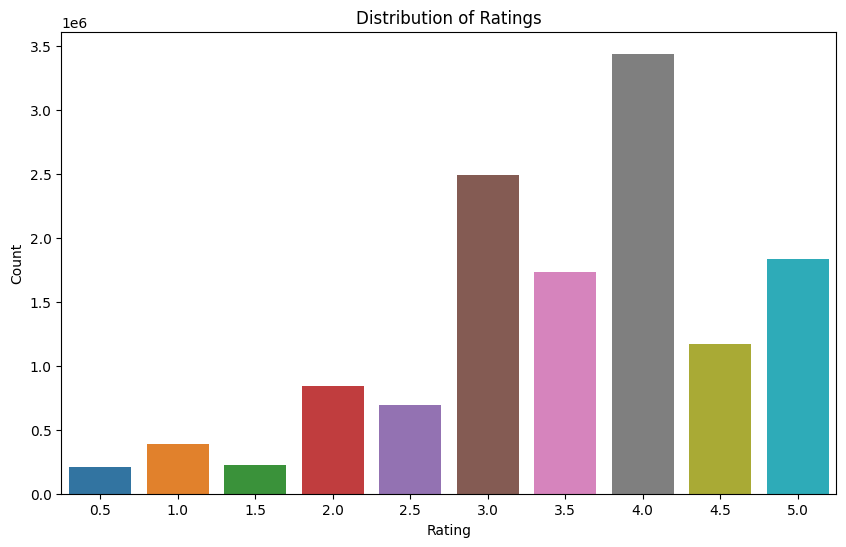

In [165]:
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=ratings_df)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


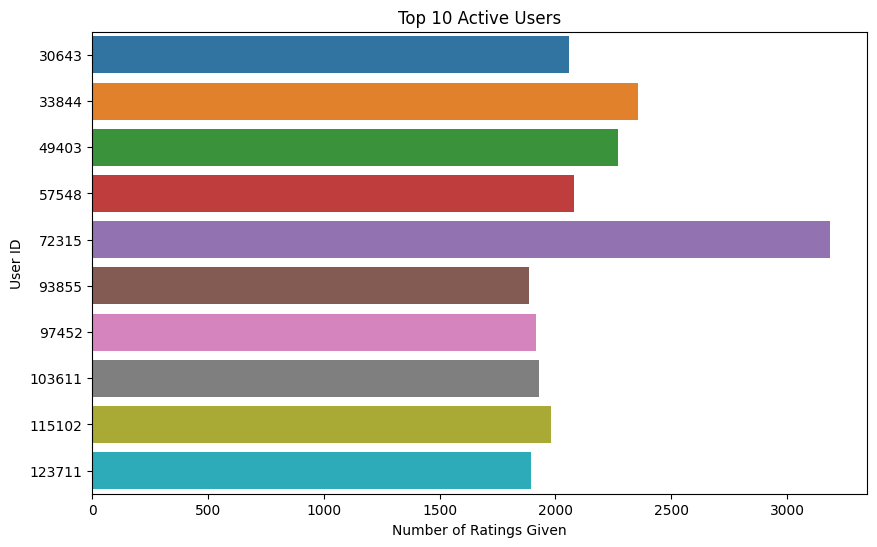

In [167]:
user_activity = ratings_df.groupby('userId').count()['rating'].sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=user_activity.values, y=user_activity.index, orient='h')
plt.title('Top 10 Active Users')
plt.xlabel('Number of Ratings Given')
plt.ylabel('User ID')
plt.show()


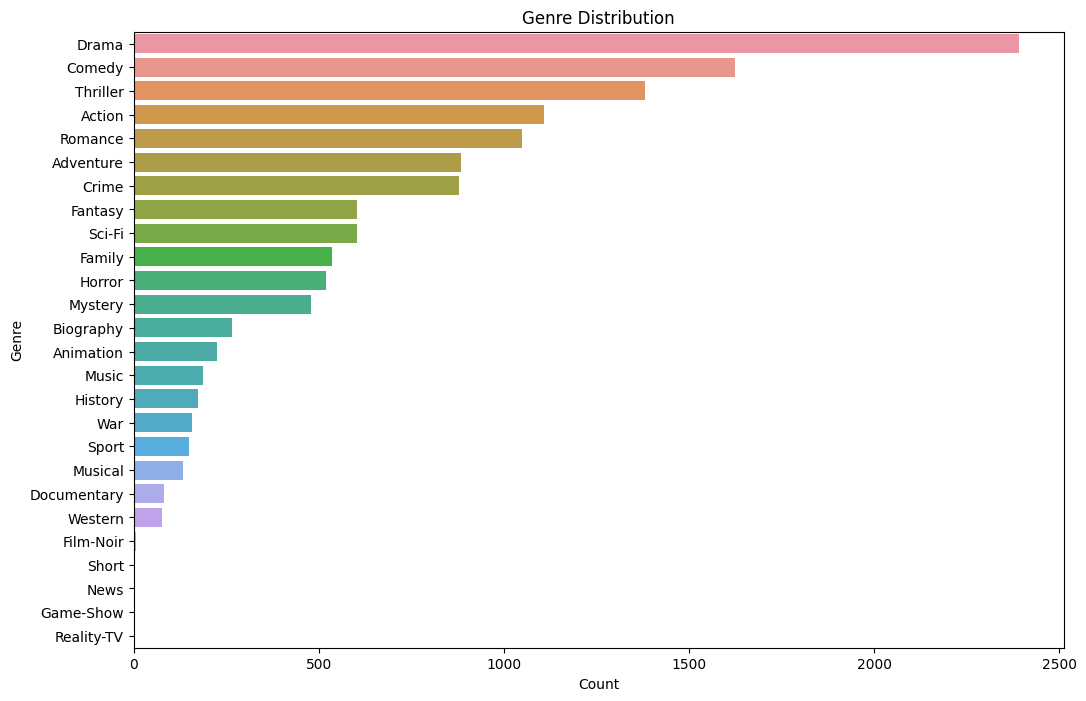

In [168]:
genre_list = movies_info_merg_df['genres'].str.split('|').explode()
plt.figure(figsize=(12, 8))
sns.countplot(y=genre_list, order=genre_list.value_counts().index)
plt.title('Genre Distribution')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()

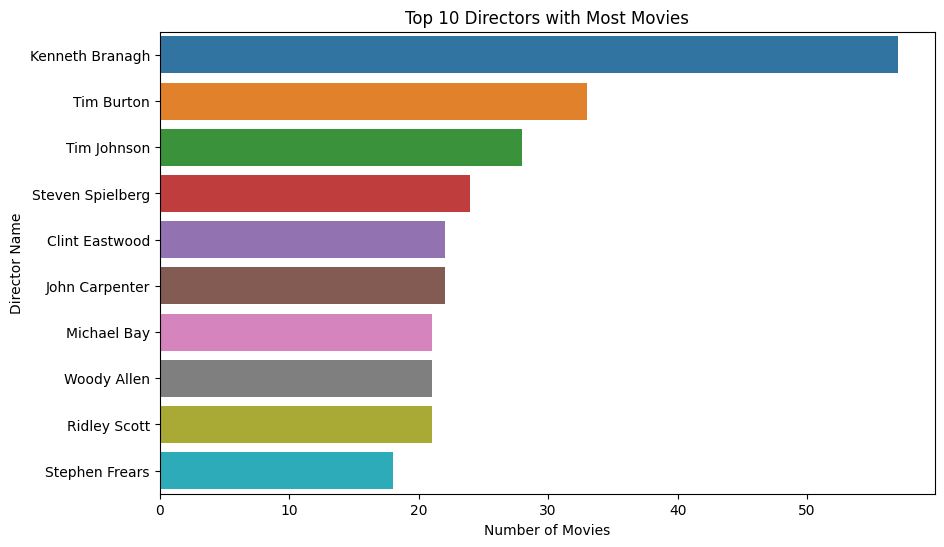

In [169]:
top_directors = movies_info_merg_df['director_name'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_directors.values, y=top_directors.index, orient='h')
plt.title('Top 10 Directors with Most Movies')
plt.xlabel('Number of Movies')
plt.ylabel('Director Name')
plt.show()


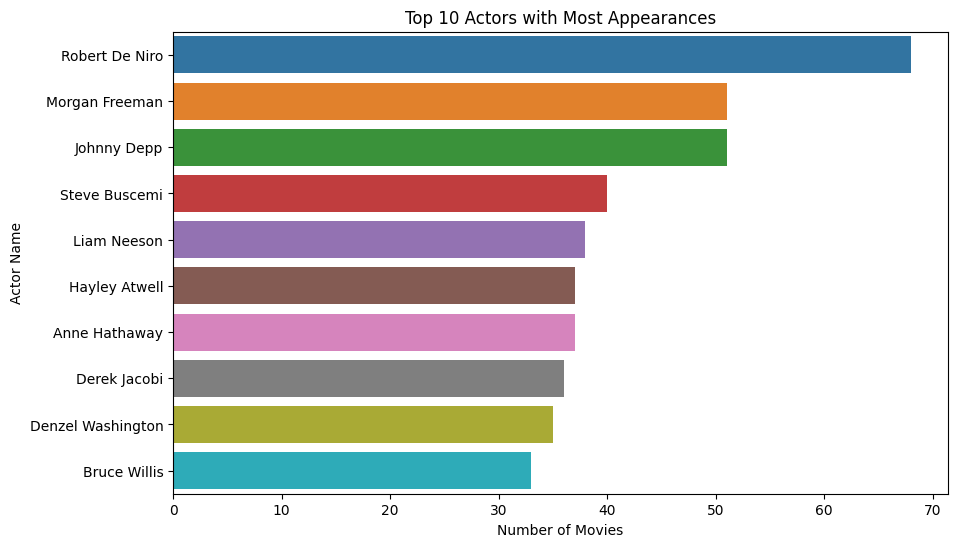

In [170]:
actor_counts = pd.concat([movies_info_merg_df['actor_1_name'], movies_info_merg_df['actor_2_name'], movies_info_merg_df['actor_3_name']]).value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=actor_counts.values, y=actor_counts.index, orient='h')
plt.title('Top 10 Actors with Most Appearances')
plt.xlabel('Number of Movies')
plt.ylabel('Actor Name')
plt.show()


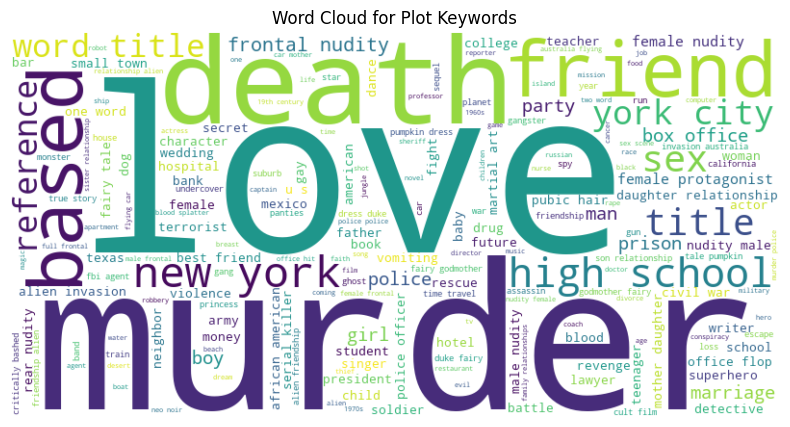

In [172]:
# Concatenate all plot keywords into a single string
all_keywords = ' '.join(movies_info_merg_df['plot_keywords'].dropna())

# Generate a word cloud image
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_keywords)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Plot Keywords')
plt.show()


## <b> API

<b>Overview</b>
This section outlines the implementation of a Flask-based API for our movie recommendation system. The API provides endpoints to search for movies, find similar movies based on user ratings, and scrape additional details from IMDb.

<b>Steps</b>

1. Flask Application Setup

    Initialize the Flask application and enable Cross-Origin Resource Sharing (CORS) to allow requests from different origins, enhancing security and compatibility.

2. Data Loading and Preprocessing

    Load the previously prepared and merged movie data (movies_info_merg.csv) and the user ratings data (ratings.csv) into pandas DataFrames.
    This data serves as the basis for the recommendation system, providing detailed movie information and user preferences.

3. Feature Extraction with TF-IDF

    Combine various textual features from the movie dataset, such as director names, actor names, genres, and plot keywords, into a single text corpus.
    Apply the TF-IDF (Term Frequency-Inverse Document Frequency) vectorizer to this combined text to convert it into a numerical matrix, capturing the importance of words in representing the content of each movie.
    This step is crucial for transforming textual data into a format suitable for machine learning algorithms.

4. Building the KNN Model

    Utilize the Nearest Neighbors algorithm, with cosine similarity as the metric, to build a model that can find movies similar to a given query.
    The model uses the TF-IDF matrix as its training data, enabling it to measure similarities between movies based on their content.

5. API Route for Movie Search

    Create an API endpoint /search that allows users to search for movies.
    This endpoint takes a movie title as input, cleans it using the clean_title function, and then uses the KNN model to find the nearest movie in the dataset.
    The search functionality is essential for allowing users to initiate the recommendation process based on a movie of interest.

6. Finding Similar Movies Based on Ratings

    Implement a method to recommend similar movies based on user ratings.
    This method identifies users who highly rated the searched movie and then recommends other movies that these users also rated highly.
    It provides a personalized recommendation by considering the preferences of similar users.

7. IMDb Data Scraping for Movie Details

    For each recommended movie, additional details such as the director, cast, story summary, and overall rating are scraped from IMDb.
    An additional function fetches the movie poster URL from the IMDb page.
    This step greatly enhances the user experience by providing rich and detailed information about each recommendation.

8. JSON Response Formatting

    Format the collected movie details and recommendations into a JSON response.
    This allows for easy integration and display of the data in various frontend applications.

9. Running the Flask Application

    Provide instructions for running the Flask application locally, making the API accessible for testing and integration.

In [53]:
def movie_poster_fetcher(imdb_link):
    """
    Fetches the URL of a movie's poster from its IMDb page.

    Args:
        imdb_link (str): The URL of the movie's IMDb page.

    Returns:
        str: The URL of the movie's poster image. Returns None if the poster URL is not found.
    """
    hdr = {'User-Agent': 'Mozilla/5.0'}  # Adjust the header as needed
    url_data = requests.get(imdb_link, headers=hdr).text
    s_data = BeautifulSoup(url_data, 'html.parser')
    imdb_dp = s_data.find("meta", property="og:image")
    movie_poster_link = imdb_dp.attrs['content'] if imdb_dp else None
    return movie_poster_link

The cell below is just to have a link of a movie to test our functions

In [81]:
sql_query_e = """ SELECT movie_imdb_link
FROM `recommandationsystem-411202.dataset.movies_info` LIMIT 10"""

query_job_e = client.query(sql_query_e)

# Fetch the results
if query_job_e.state == 'DONE':
    dsf = query_job_e.to_dataframe()
    # Display the DataFrame
    print(dsf['movie_imdb_link'][5])
else:
    print(query_job_e.result())

http://www.imdb.com/title/tt2355844/?ref_=fn_tt_tt_1


In [160]:
def get_movie_info(imdb_link):
    """
    Scrapes a movie's detailed information from its IMDb page.

    Args:
        imdb_link (str): The URL of the movie's IMDb page.

    Returns:
        tuple: A tuple containing the director's name, cast, story summary,
               additional information, and movie rating. If certain information
               is not found, 'N/A' is returned in its place.
    """
    hdr = {'User-Agent': 'Mozilla/5.0'}  # Adjust the header as needed
    url_data = requests.get(imdb_link, headers=hdr).text
    s_data = BeautifulSoup(url_data, 'html.parser')
    movie_story = s_data.find('p', class_='sc-466bb6c-3 fOUpWp')
    r_movie_story = movie_story.text if movie_story else 'N/A'
    people = s_data.find_all('div', class_='ipc-metadata-list-item__content-container')
    movie_director = people[0].text if people[0] else 'N/A'
    movie_cast = people[1].text if people[1] else 'N/A'
    movie_desc_ul = s_data.find('ul', class_='ipc-inline-list ipc-inline-list--show-dividers sc-d8941411-2 cdJsTz baseAlt')
    if movie_desc_ul:
        # Extract text from each list item
        movie_desc_list = [li.get_text(strip=True) for li in movie_desc_ul.find_all('li')]
    
        # Join the list items into a single string separated by spaces
        movie_descro = ' '.join(movie_desc_list)
    else:
        movie_descro = "Description not found"
    rating = s_data.find("span", class_="sc-bde20123-1 cMEQkK").text if s_data.find("span", class_="sc-bde20123-1 cMEQkK") else "N/A"  # Update class name as needed
    return movie_director, r_movie_story, movie_descro, rating



In [161]:
get_movie_info(dsf['movie_imdb_link'][4])

('David JasonBruce AlexanderJohn Lyons',
 'DI Jack Frost is an unconventional policeman with sympathy for the underdog and an instinct for moral justice. Sloppy, disorganized, and disrespectful, he attracts trouble like a magnet.DI Jack Frost is an unconventional policeman with sympathy for the underdog and an instinct for moral justice. Sloppy, disorganized, and disrespectful, he attracts trouble like a magnet.DI Jack Frost is an unconventional policeman with sympathy for the underdog and an instinct for moral justice. Sloppy, disorganized, and disrespectful, he attracts trouble like a magnet.',
 'TV Series 1992–2010 TV-MA 1h 45m',
 '7.9')